Como sabemos, Rafael Nadal ha perdido por primera vez en la historia tres tie-breaks seguidos. Hoy nos planteamos analizar datos históricos de los partidos jugados desde el 2000 hasta el 2016 y, finalmente gracias a Machine Learning, predecir quién ganará cada partido.

Este proceso es completamente extrapolable a otros proyectos y lo realizaremos en el lenguaje de programación Python.

# Importamos las librerias necesarias

In [1]:
%load_ext autoreload
%autoreload 2

Para poder realizar todas las tareas, necesitaremos los siguientes imports:

In [2]:
import pandas as pd
import sklearn
from random import seed
from random import randint
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
seed(1)
warnings.simplefilter("ignore") # Ignoramos los warnings

# Carga de datos

Los datos históricos de los que disponemos han sido extraídos de la web de Kaggle, dónde tenemos acceso a un conjunto de datos de todos los partidos jugados desde el 2000 hasta el 2016.

Puedes consultar la fuente en el siguiente enlace: https://www.kaggle.com/jordangoblet/atp-tour-20002016

In [137]:
df_original = pd.read_csv('Data.csv', encoding = 'latin1') # leemos el csv

En este conjunto podemos encontrar variables como:
- Dónde se jugó el torneo
- Fecha
- Tipo de superficie
- Ganador
- Puntos del ganador (antes del torneo)
- Ranking del ganador (antes del torneo)
- Perdedor
- Puntos del perdedor (antes del torneo)
- Ranking del perdedor (antes del torneo)
- Información de las probabilidades de casas de apuestas
- Información del número de juegos ganados/perdidos por el ganador/perdedor en los diferentes matches del partido

In [5]:
df_original.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,3/01/2000,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Tal y como se puede observar, se ha recalcado que, por ejemplo, los puntos del ganador han sido extraídos antes del torneo. Esto, aunque parezca insignificante, es un aspecto crucial. Pues, en caso de que no fuera así, en el momento de entrenar el modelo, le estaríamos proveyendo de datos que no estarán disponibles en el momento de realizar la predicción. Es decir, si antes de comenzar el torneo se le han sumado al ganador los puntos del mismo, automáticamente el modelo sería capaz de encontrar una correlación por el aumento de los puntos y sabría quién es el ganador.

Usar datos que no estarán disponibles en el momento de la predicción para construir el modelo se conoce como data leakage, y es uno de los problemas que un data scientist debe evitar a toda costa.

El caso más famoso de data leakage es el de la predicción de la neumonía, donde existía una columna que decía si el paciente se le había prescrito o no la medicación para la neumonía. En caso de añadir dicha columna, ya sabríamos que el paciente ha sido diagnosticado con neumonía y por eso ha empezado el tratamiento. Esta información no será conocida en el momento de la predicción y por lo tanto se considera un caso claro de data leakage. Si bien es cierto que en este caso es algo muy evidente, en otros proyectos puede que no lo sea tanto, y es por esta razón por la que debemos prestar especial atención al significado y forma de calcular que tienen todas y cada una de las variables que nuestro modelo usará.

Como no es este el caso, sí que podremos añadir estas variables.

Asimismo, existen otras variables como las relacionadas con las casas de apuestas. En este caso en la funte no se deja claro el momento de recibir esa información, por lo que sí podríamos hacer un data leakage. Lo ideal sería que desde negocio nos dejen claro cuándo se calculan y se saben estas variables.

# Análisis exploratorio inicial

En primer lugar realizaremos un análisis exploratorio inicial de algunas de las variables que finalmente usaremos para la predicción.

In [138]:
# Función que extrae el año y el mes de la fecha y lo añade como dos columnas nuevas al dataset
def date_wrangle(_df):
    _df['Year'] = pd.DatetimeIndex(_df['Date']).year
    _df['Month'] = pd.DatetimeIndex(_df['Date']).month
    
    return _df

In [139]:
df_original = date_wrangle(df_original) # Creamos las columnas de año y mes
matches_won = df_original[['Tournament', 'Winner','Surface', 'Round', 'Year', 'Month', 'WRank']]

## Ganadores por Superficie

In [9]:
surfaces = df_original['Surface'].unique()

In [10]:
# Realizamos un group by por la superficie y el ganador y contamos el número de triunfos que ha conseguido y, 
# posteriormente, nos quedamos con el top 10
surfaces_gb = matches_won.groupby(['Surface','Winner'], as_index=False)['Tournament'].count()
surfaces_gb.columns = ['Surface','Player', 'Wins']
t10_wins_surface = surfaces_gb.groupby(['Surface']).apply(lambda x: x.nlargest(10,['Wins'])).reset_index(drop=True)

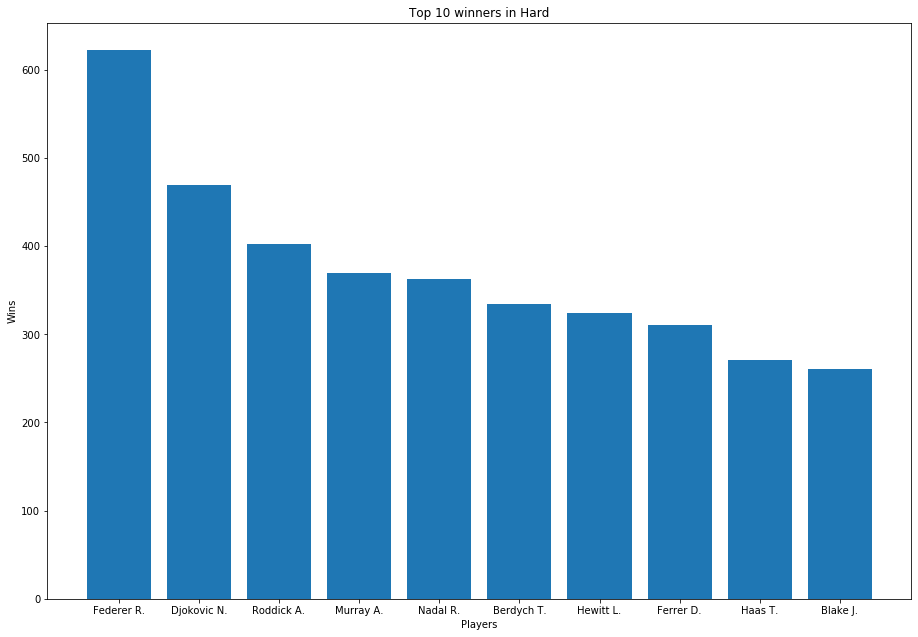

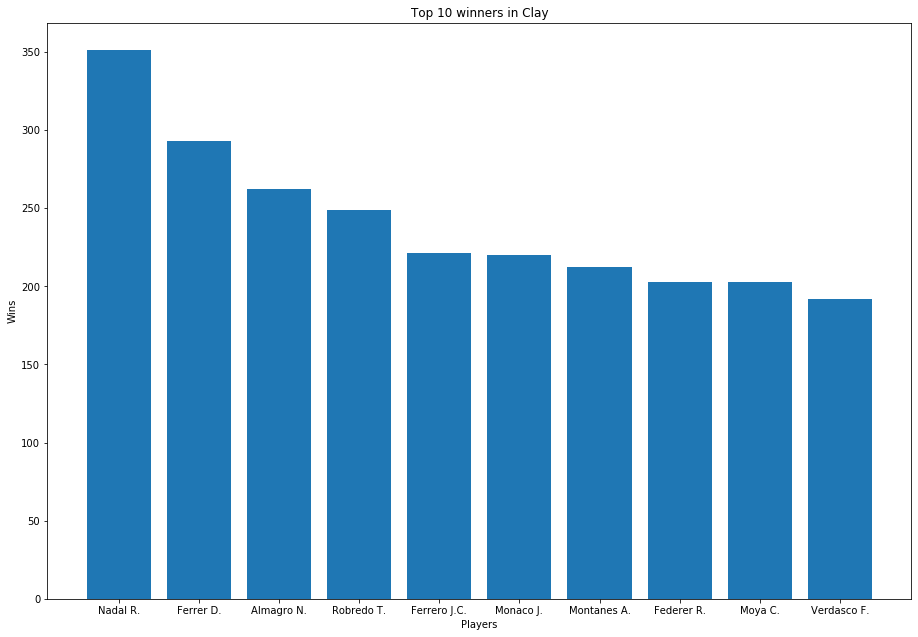

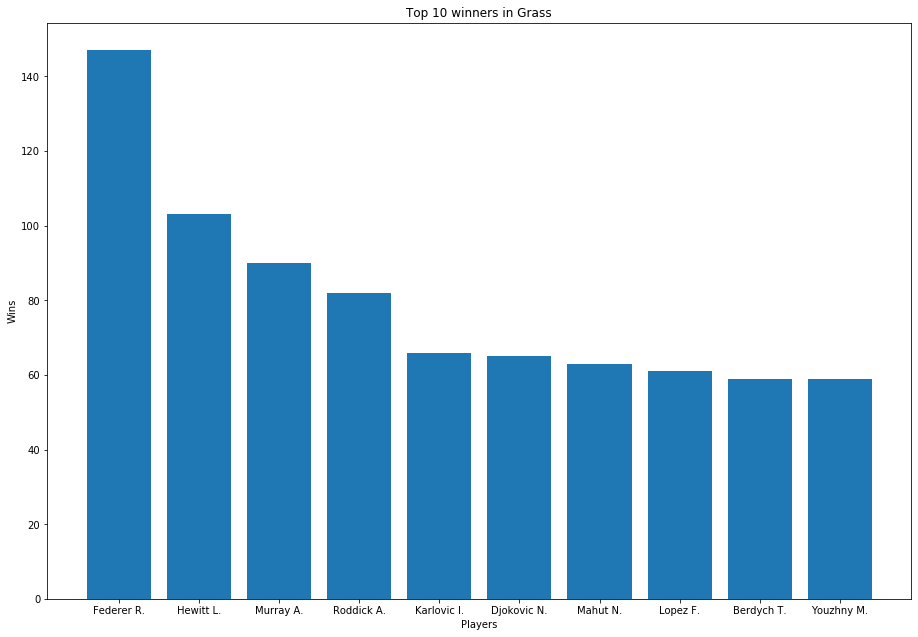

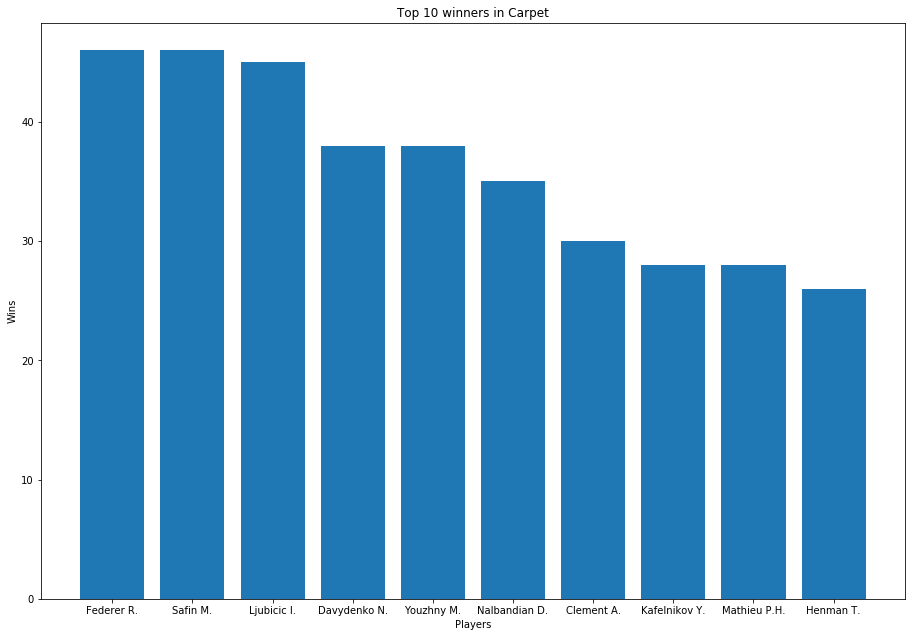

In [11]:
# Realizamos un bucle para mostrar el top 10 de ganadores para cada una de las superficies
for s in surfaces:
    x = t10_wins_surface[t10_wins_surface['Surface']==s]['Player']
    y = t10_wins_surface[t10_wins_surface['Surface']==s]['Wins']
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])
    ax.bar(x, y)
    plt.ylabel('Wins')
    plt.xlabel('Players')
    plt.title("Top 10 winners in " + s)
    plt.show()

Si bien es cierto que se puede ver claramente como el maestro Roger Federer encabeza la mayoría de las gráficas, y es que a sus 38 años de edad sigue dando lecciones impecables de tenis allá donde va. Siendo considerado el rey de la hierba se puede dilucidar esa diferencia de victorias frente al top 9 restante de la lista.

Sin embargo, esto no se cumple en tierra batida (Clay), siendo el manacorí Rafael Nadal líder en esta superficie con récords (casi) insuperables.

## Top 10 jugadores respecto del número de torneos ganados

In [13]:
# Nos quedamos únicamente con aquellas filas del dataset cuya columna Round toma el valor de 'The Final', es decir,
# el último partido de cada torneo el cuál marcará el ganador de éste.
# Posteriormente nos quedamos con el top 10 de jugadres que más torneos ganados tienen
wins_tournament = matches_won[matches_won['Round'] == 'The Final'][['Tournament', 'Winner']]
t10_wins_tournament = wins_tournament.groupby('Winner', as_index=False)['Tournament'].count().sort_values(['Tournament'], ascending=False).head(10)
t10_wins_tournament.columns = ['Player', 'Tournaments_won']

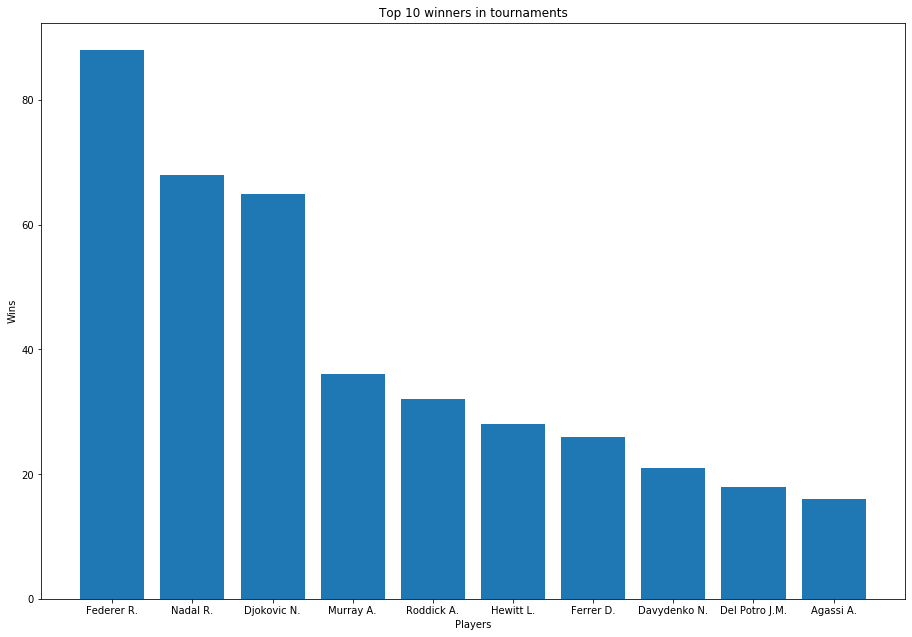

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(t10_wins_tournament['Player'], t10_wins_tournament['Tournaments_won'])
plt.ylabel('Wins')
plt.xlabel('Players')
plt.title("Top 10 winners in tournaments")
plt.show()

## "Big Three"

Tal y como hemos visto en todas las gráficas anteriores, hay jugadores que se encuentran presentes en todas ellas. Pero, existen claramente tres cuya hegemonía es incuestionable. Estamos hablando de los "Big Three" o los "Tres Grandes"; Federer, Nadal y Djokovic. Y es que una década después siguen encabezando los rankings, habiendo conseguido 51 de los últimos 59 títulos de Grand Slam.

Es por ello por lo que realizaremos un análisis centrandonos en estos tres jugadores.

In [15]:
bt = ['Federer R.', 'Nadal R.', 'Djokovic N.']
matches_won_bt = matches_won[matches_won['Winner'].isin(bt)] # Nos quedamos con los partidos jugados por los big three

### Triunfos por fecha

#### Partidos ganados por año

In [16]:
# Igual que en el caso para todos los jugadores, miramos el número de partidos ganados para cada uno de los big three
matches_won_bt_year = matches_won_bt.groupby(['Year', 'Winner'], as_index=False)['Tournament'].count()
matches_won_bt_year.columns = ['Year', 'Player', 'Wins']

Text(0.5, 0.98, 'Matches won by Year')

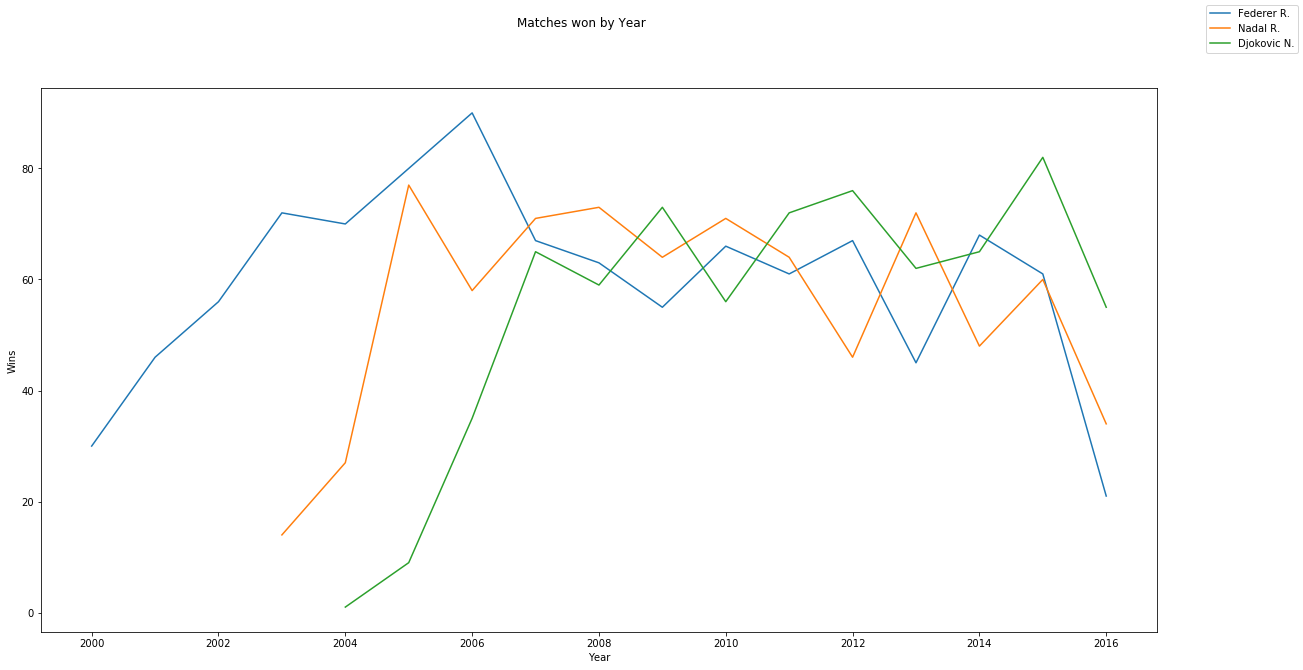

In [17]:
fig = plt.figure(figsize=(20,10))
for p in bt:
    sns.lineplot(x='Year', y='Wins', data=matches_won_bt_year[matches_won_bt_year['Player']==p])
fig.legend(labels=bt)
fig.suptitle('Matches won by Year')

#### Torneos ganados por año

In [18]:
tournaments_won_bt_year = matches_won_bt[matches_won_bt['Round']=='The Final'].groupby(['Year', 'Winner'], as_index=False)['Tournament'].count()
tournaments_won_bt_year.columns = ['Year', 'Player', 'Wins']

Text(0.5, 0.98, 'Tournaments won by Year')

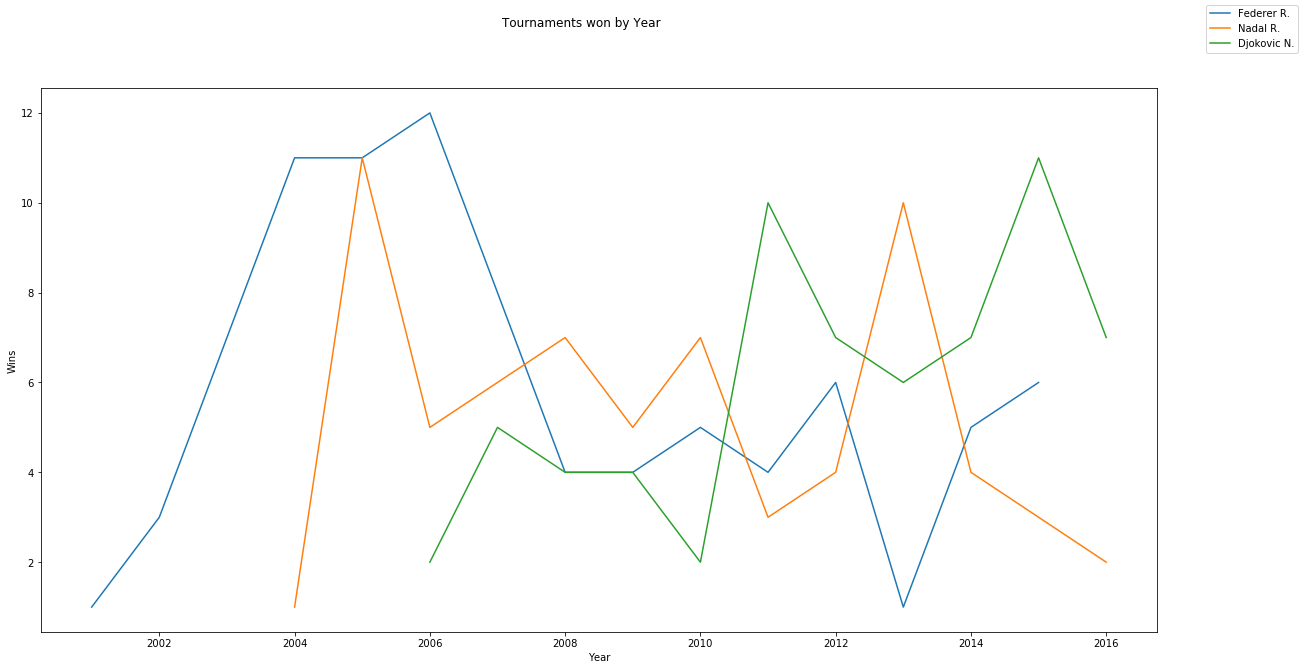

In [156]:
fig = plt.figure(figsize=(20,10))
for p in bt:
    sns.lineplot(x='Year', y='Wins', data=tournaments_won_bt_year[tournaments_won_bt_year['Player']==p])
fig.legend(labels=bt)
fig.suptitle('Tournaments won by Year')

#### Ranking ATP por año

In [20]:
matches_won_bt['WRank'] = matches_won_bt['WRank'].astype('int')

Text(0.5, 0.98, 'Ranking by Year')

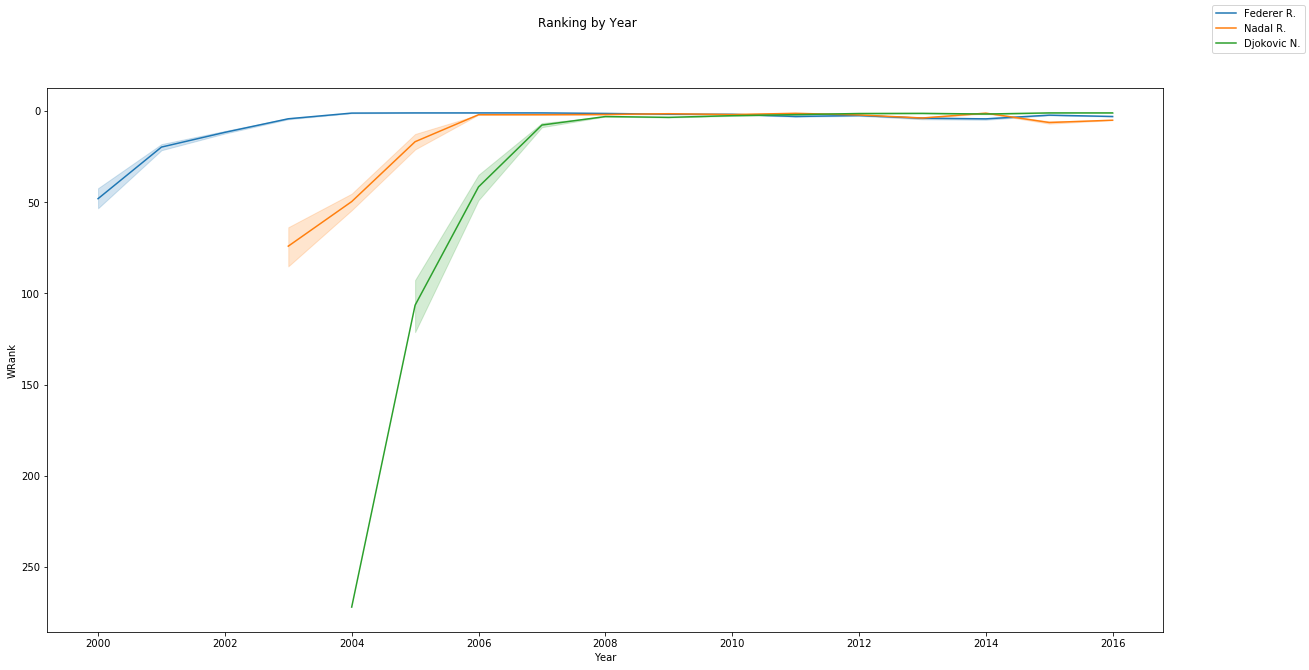

In [159]:
fig = plt.figure(figsize=(20,10))
for p in bt:
    sns.lineplot(x='Year', y='WRank', data=matches_won_bt[matches_won_bt['Winner']==p])
fig.legend(labels=bt)
plt.gca().invert_yaxis()
fig.suptitle('Ranking by Year')

En lugar de coger todo el histórico, vamos a ver a partir de 2007, pues sabemos que a partir del 2008 es cuando comenzaron las lesiones de Nadal.

In [22]:
# Filtramos los partidos ganados por los bigthree en años posteriores o iguales a 2007
matches_won_bt_filter = matches_won_bt[matches_won_bt['Year'] >= 2007]

Text(0.5, 0.98, 'Ranking by Year')

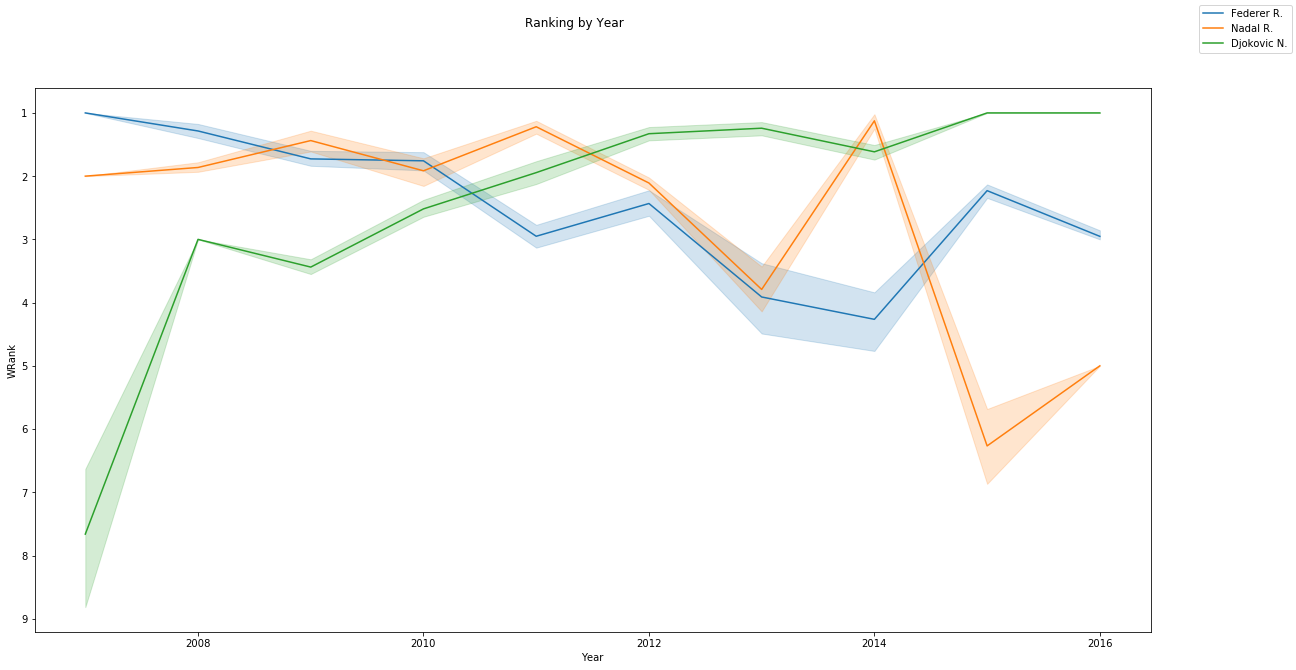

In [158]:
fig = plt.figure(figsize=(20,10))
for p in bt:
    sns.lineplot(x='Year', y='WRank', data=matches_won_bt_filter[matches_won_bt_filter['Winner']==p])
fig.legend(labels=bt)
plt.gca().invert_yaxis()
fig.suptitle('Ranking by Year')

Podemos ver como Nadal a partir de su lesión en la rodilla (que comenzó en el 2008) y se acentuó del 2011 en adelante, ha causado estragos en el manacorí. No obsante, si tuvieramos los datos de años posteriores veríamos como, a pesar de las vicisitudes, su dominio incuestionable le ha devuelto al top 1.

A diferencia de Djokovic que desde esa fecha pudo coger carrerilla y situarse en la cúspide del ranking. Probablemente podríamos ver su lesión de codo si tuvieramos los datos del 2017 en adelante, pues eso le supuso la retirada de los campoenatos.

### Sets por superficie

In [24]:
sets_won_bt_surface = matches_won_bt.groupby(['Surface', 'Winner'], as_index=False)['Tournament'].count()
sets_won_bt_surface.columns = ['Surface', 'Player', 'Sets_won']

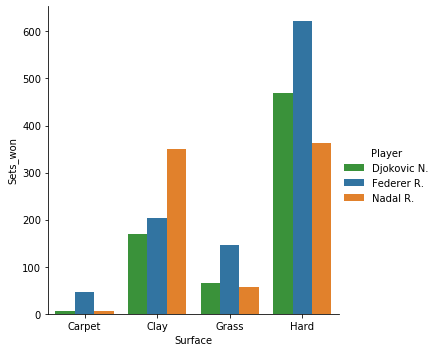

In [155]:
palette ={"Federer R.":"C0","Nadal R.":"C1","Djokovic N.":"C2"}
sns.factorplot(x='Surface', y='Sets_won', hue='Player', data=sets_won_bt_surface, kind='bar', palette=palette)

# Data wrangling

## Fecha

In [26]:
# Función para filtrar el dataset a partir del año pasado como parámetro year_from
def date_filter(_df, year_from):
    _df = _df[_df['Year'] >= year_from]
    
    return _df

## Filtrado de columnas

Para este artículo, vamos a hacer uso únicamente de estas columnas. 

In [27]:
columns_to_use = ['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of',
                  'WRank', 'LRank', 'WPts', 'LPts', 'Winner', 'Loser', 'Month', 'Year'
                 ]

In [28]:
# Función que se quedará únicamente con las columnas deseadas
def filter_columns(_df):
    return _df[columns_to_use]

## Computar player 1 / 2

In [29]:
# Funciones para computar player 1 y player 2

# Función que realiza un número aleatorio entero entre 1 y 2. En caso de ser 1, player1 será winner y player2, looser.
def get_player1(winner, loser):
    random_number = randint(1, 2)
    if random_number == 1:
        return winner
    else:
        return loser

def get_player2(winner, loser, player1):
    if player1 == winner:
        return loser
    else:
        return winner

def get_player1_points(winner, loser, player1, WPts, LPts):
    if player1 == winner:
        return WPts
    else:
        return LPts

def get_player2_points(winner, loser, player1, WPts, LPts):
    if player1 == winner:
        return LPts
    else:
        return WPts
    
def get_player1_atprank(winner, loser, player1, WRank, LRank):
    if player1 == winner:
        return WRank
    else:
        return LRank
    
def get_player2_atprank(winner, loser, player1, WRank, LRank):
    if player1 == winner:
        return LRank
    else:
        return WRank

In [30]:
# Aplicamos todas las funciones lambda para cambiar winner y loser por player1 y player2 de forma aleatoria.
# Asimismo, una vez player1 y player2 tome el valor de winner o loser indistintamente, las demás columnas tales como 
# WPts, LPTs, etc., deberán ser cambiadas para hacer referencia al player1/2
def create_player_1_2(_df):
    _df['Player1'] = _df.apply(lambda x: get_player1(x['Winner'], x['Loser']), axis=1)
    _df['Player2'] = _df.apply(lambda x: get_player2(x['Winner'], x['Loser'], x['Player1']), axis=1)
    _df['Player1_Points'] = _df.apply(lambda x: get_player1_points(x['Winner'], x['Loser'], x['Player1'], x['WPts'], x['LPts']), axis=1)
    _df['Player2_Points'] = _df.apply(lambda x: get_player2_points(x['Winner'], x['Loser'], x['Player1'], x['WPts'], x['LPts']), axis=1)
    _df['Player1_ATPRank'] = _df.apply(lambda x: get_player1_atprank(x['Winner'], x['Loser'], x['Player1'], x['WRank'], x['LRank']), axis=1)
    _df['Player2_ATPRank'] = _df.apply(lambda x: get_player2_atprank(x['Winner'], x['Loser'], x['Player1'], x['WRank'], x['LRank']), axis=1)
    
    return _df

En el dataset original podemos ver como tenemos una columna Winner y una columna Loser para indicar el ganador y el perdedor del partido respectivamente. Si queremos realizar una predicción de quién ganará el partido con estas columnas, sería directo ya que siempre Winner gana a Loser. Además de que partiríamos de la base de que ya conocemos previamente el resultado antes de realizar la predicción, por lo que estaríamos comentiendo data leakage.

Para solventar esto hemos distribuido Winner y Loser de forma aleatoria de manera que se distribuyan entre Player1 ó Player2, cambiando las variables de los puntos y el ranking del ganador y del perdedor acorde al valor nuevo que hayan tomado. De esta manera ya podemos construir nuestro label y realizar las primeras predicciones. 

## Label

In [31]:
# Función que generará el label. En caso de que el player1 sea el winner, devolverá 1 y 0 en caso contrario.
def build_label(_df):
    def _create_label(winner, player1):
        if winner == player1:
            return 1
        else:
            return 0
        
    _df['label'] = _df.apply(lambda x: _create_label(x['Winner'], x['Player1']), axis=1)
    
    return _df

Una vez hemos distribuido Winner y Loser de forma aleatoria entre Player1 y Player2, nuestro label será dicotómico y lo construiremos de tal manera que tome el valor de 1 cuando Player1 gane el partido a Player2 y 0 en caso contrario. Es decir, estaríamos hablando de una clasificación binaria.

La construcción del label es una de las tareas más importantes en un proyecto de Machine Learning. De hecho, definirlo al comienzo del proyecto con el mayor detalle posible es una de nuestras prioridades, pues marcará muchas de las actividades posteriores. El label debe tener un significado claro y conciso y debe ser interpretable por negocio, para que una vez el modelo se reejecute con la periodicidad deseada y sus resultados se integren con el sistema de información, los expertos/as puedan tomar las decisiones y acciones pertinentes.

## Eliminación de columnas

In [32]:
def drop_columns(_df):
    _df.drop(columns=['Winner', 'Loser', 'Date', 'WRank', 'LRank', 'WPts', 'LPts'], inplace=True)
    
    return _df

Eliminamos las columnas que hemos utilizado para el cambio a Player1 Player2 que ya no necesitamos.

## Función que encapsula todas las anteriores

In [33]:
def df_wrangle(_df, year_from=2010):
    _df = date_wrangle(_df)
    _df = date_filter(_df, year_from)
    _df = filter_columns(_df)
    _df = create_player_1_2(_df)
    _df = build_label(_df)
    _df = drop_columns(_df)
    return _df

Para ayudarnos a que el proceso sea algo más cómodo para reejecutar y mantener un orden, hemos creado una función que encapsula todas las funciones de transformación que necesitamos. 

In [34]:
df = df_wrangle(df_original)

# EDA y limpieza de datos

In [35]:
df.columns

Index(['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Month', 'Year', 'Player1', 'Player2', 'Player1_Points',
       'Player2_Points', 'Player1_ATPRank', 'Player2_ATPRank', 'label'],
      dtype='object')

In [36]:
df.tail()

,Location,Tournament,Series,Court,Surface,Round,Best of,Month,Year,Player1,Player2,Player1_Points,Player2_Points,Player1_ATPRank,Player2_ATPRank,label
46647,St. Petersburg,St. Petersburg Open,ATP250,Indoor,Hard,Quarterfinals,3,9,2016,Zverev A.,Youzhny M.,1425.0,846.0,27.0,53.0,1
46648,St. Petersburg,St. Petersburg Open,ATP250,Indoor,Hard,Quarterfinals,3,9,2016,Troicki V.,Wawrinka S.,1295.0,6260.0,33.0,3.0,0
46649,St. Petersburg,St. Petersburg Open,ATP250,Indoor,Hard,Semifinals,3,9,2016,Berdych T.,Zverev A.,3390.0,1425.0,9.0,27.0,0
46650,St. Petersburg,St. Petersburg Open,ATP250,Indoor,Hard,Semifinals,3,9,2016,Wawrinka S.,Bautista Agut R.,6260.0,1950.0,3.0,16.0,1
46651,St. Petersburg,St. Petersburg Open,ATP250,Indoor,Hard,The Final,3,9,2016,Zverev A.,Wawrinka S.,1425.0,6260.0,27.0,3.0,1


Una vez hemos realizado las transformaciones iniciales, este sería el aspecto de nuestro dataset.

## EDA

### Análisis del Label

In [37]:
df['label'].value_counts()

1    9056
0    9016
Name: label, dtype: int64

Antes de empezar con un análisis más específico, hemos creído interesante estudiar como de desbalanceado/balanceado se encontraba nuestro label (por si hubiera que aplicar técnicas de balanceo del label). Al haber un número bastante grande de filas y utilizar un número pseudoaleatorio generado (PRNG), intuíamos que se encontraría cercano a un ratio de 0.5. Tal y como podemos ver, tenemos un ratio de 0.501 frente a un 0.499, por lo que no necesitaríamos aplicar dichas técnicas.

Esta comprobación entraría dentro de las buenas prácticas de Machine Learning, ya que existen problemas, tales como predicción de abandono de clientes o detección de fraude en tarjetas de crédito, donde es crucial aplicar medidas para contrarestar esta situación.

### Análisis de nulos

In [38]:
df.shape

(18072, 16)

In [39]:
df.isna().sum()

Location            0
Tournament          0
Series              0
Court               0
Surface             0
Round               0
Best of             0
Month               0
Year                0
Player1             0
Player2             0
Player1_Points     15
Player2_Points     22
Player1_ATPRank    15
Player2_ATPRank    24
label               0
dtype: int64

En el análisis de valores nulos podemos ver que prácticamente no representan ni un 1% del total de filas. Al tratarse de un número tan pequeño, decidimos eliminarlos.

In [40]:
df.dropna(inplace=True)

In [41]:
df.isna().sum()

Location           0
Tournament         0
Series             0
Court              0
Surface            0
Round              0
Best of            0
Month              0
Year               0
Player1            0
Player2            0
Player1_Points     0
Player2_Points     0
Player1_ATPRank    0
Player2_ATPRank    0
label              0
dtype: int64

Podemos ver como ya no tenemos ningún valor nulo.

# Versión 1

## Train test split

In [42]:
y = df.pop('label') # Cogemos la columna label, la asignamos a y y la borramos de df
X = df

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=124)

In [44]:
X_train.columns

Index(['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Month', 'Year', 'Player1', 'Player2', 'Player1_Points',
       'Player2_Points', 'Player1_ATPRank', 'Player2_ATPRank'],
      dtype='object')

Para poder entrenar nuestro modelo y posteriormente evaluar su bondad, necesitamos dividir nuestro conjunto de datos en un conjunto de entrenamiento (train) y un conjunto de testeo (test).

## Pipeline de preprocesado

In [45]:
categorical_features = ['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round', 'Best of',
                        'Player1', 'Player2', 'Player1_ATPRank', 'Player2_ATPRank', 'Month', 'Year'
                       ]

numerical_features = ['Player1_Points', 'Player2_Points']

Ahora es el momento de crear un pipeline, es decir, un conjunto de transformaciones que se van a aplicar a cada una de las columnas (o features) que analizará nuestro modelo para realizar la predicción.

Hemos realizado la división entre numéricas y categóricas, pues cada una de estas dos categorías recibirá un tratamiento especial.

In [46]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

Escalaremos el valor de las varibles numéricas para centrarlos en el cero y mantener la varizanza de las mismas en la misma maginitud para evitar que variables con valores muy grandes dominen a aquellas con valores más pequeños.

In [47]:
categorical_transformer = Pipeline(steps=[('targeten', TargetEncoder())])

Existen numerosas formas de tratar las variables categóricas (OneHot Encoding, Target Encoding, Embeddings, CatBoost Encoding, ...). En este caso nos hemos decantado por Target Encoding, es decir, un valor fruto de la combinación de la probabilidad del target (label) dado un valor categórico concreto y la probabilidad del target respecto al dataset completo.

In [48]:
preprocessor =\
    ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features)
            ,('cat', categorical_transformer, categorical_features)
        ]
    )

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', lgb.LGBMClassifier())])

Creamos el ColumnTransformer con los pipelines de tanto las variables numéricas como las categóricas. Asimismo, hemos añadido un step extra en el añadimos el modelo que queremos entrenar. En este caso, vamos a utilizar un LightGBM.

Los pipelines se pueden entender como un objeto capaz de aunar diferentes pasos (o steps) que se ejecutarán sobre un subconjunto de columnas.

El ColumnTransformer nos permitirá realizar diversas transformaciones de forma aislada a diferentes subconjuntos de columnas. Una vez se han llevado todas las transformaciones a cabo, volverán a ser aunadas en un único objeto. Es muy útil cuando tenemos columnas con datos heterogéneos. Además, posee el parámetro n_jobs, lo que nos permite ejecutar en paralelo las tranformaciones, aprovechando así nuestra capacidad de cómputo al máximo.

El objetivo principal del uso de pipelines es la de poder reejecutar y reutilizar las mismas transformaciones. Es decir, si tenemos un modelo que nos predice aquellos clientes que potencialmente abandonarán la empresa en seis meses y hemos estudiado exhaustivamente una serie de transformaciones que sabemos que hacen que el comportamiento del modelo sea el óptimo, cuando se añada un mes más de datos, nos interesará aplicar las mismas transformaciones y, posteriormente realizar la predicción a futuro.

In [49]:
clf.fit(X_train, y_train)
print("Accuracy train: %.3f" % clf.score(X_train, y_train))
print("Accuracy test: %.3f" % clf.score(X_test, y_test))

Accuracy train: 0.768
Accuracy test: 0.664


Para evaluar la bondad del modelo, vamos a utilizar la métrica "accuracy", es decir, el total de casos que hemos clasificado correctamente frente al total de casos vistos.

Podemos ver que en el conjunto de test el modelo consigue un 66.4% de accuracy.

## Importancia de variables

In [50]:
pd.DataFrame(list(zip(clf.steps[1][1].feature_importances_.ravel(), X_train.columns)), columns=["Importance", "Feature"]).sort_values(['Importance'], ascending=False)

,Importance,Feature
10,531,Player2
9,512,Player1
12,306,Player2_Points
0,300,Location
1,282,Tournament
11,245,Player1_Points
3,203,Court
2,177,Series
13,133,Player1_ATPRank
14,102,Player2_ATPRank


La importancia de variables es una de las partes más importantes en un proyecto de Machine Learning, ya que nos puede proveer de información muy útil. Es tan importante saber el qué como el por qué, pues este feedback podrá ser utilizado por negocio para tomar las acciones pertinentes. Por ejemplo, en un proyecto de predicción de abandono de clientes podríamos tomar acciones ad-hoc para cada uno de los posibles abandonos sabiendo aquellas razones que le harán tomar esa decisión.

En este caso podemos ver como los jugadores toman un papel muy importante en el resultado de la predicción. Asimismo también parece haber una correlación bastante grande entre los puntos que tienen en el momento de jugar el partido con el resultado del mismo. Tiene bastante sentido pues si están más bajos de forma en un periodo en concreto, tendrán más posibilidades de perder el partido. Además también sabemos que existen jugadores que tienen una predeilección hacia ciertos torneos, y podemos ver como también tiene bastante protagonismo.

# Versión 2

Imaginemos que quisiéramos evaluar si el modelo esta teniendo en cuenta o no el orden en el que Player1 y Player2 aparecen, haciendo así asunciones incorrectas por lo que realizaremos un experimento invirtiendo el Player1 con el Player2 (junto con todas sus variables). 

Es decir, si un partido en un Grand Slam y fecha en concreto juega Nadal contra Federer con label 1 (ha ganado Nadal) y el modelo lo predice correctamente, si en la fila se invirtese Player1 con Player2 (junto con todas sus variables), lo seguiría prediciendo correctamente?

Imaginemos este escenario simplificado:

| Player1  | Player2  | Partido | ... | Valor real | Predicción |
|----------|----------|---------|-----|------------|------------|
| Nadal    | Federer  | x       | ... | 1          | 1          |
| Federer  | Nadal    | x       | ... | 1          | 1          |
| Djokovic | Nadal    | y       | ... | 0          | 0          |
| Nadal    | Djokovic | y       | ... | 0          | 1          |

En este caso, sólo en el 50% de los casos ha sido capaz de aprender que el orden de los jugadores no debe ser significativo.

Esto sólo es un ejemplo de cómo evaluar mejor nuestro modelo. No obstante, esto es sólo un ejemplo para concienciar de la importancia de las métricas personalizadas que tienen un impacto directo en negocio. En cada proyecto se debería encontrar (al menos) una métrica que evalúe de manera transversal la predicción del modelo con beneficio que aporta al proceso/empresa o a lo que se esté evaluando en ese caso en concreto.

In [125]:
# Realizamos una copia de test
X_test_c = X_test.copy(deep=True)

In [126]:
# En esta copia, invertimos Player 1 por Player 2
X_test_c['aux'] = X_test_c['Player1']
X_test_c['Player1'] = X_test_c['Player2']
X_test_c['Player2'] = X_test_c['aux']

In [127]:
# Invertimos también los puntos del jugador 1 por los del jugador 2
X_test_c['aux'] = X_test_c['Player1_Points']
X_test_c['Player1_Points'] = X_test_c['Player2_Points']
X_test_c['Player2_Points'] = X_test_c['aux']

In [128]:
# Por último, sólo nos queda invertir el Ranking ATP del jugador 1 y 2
X_test_c['aux'] = X_test_c['Player1_ATPRank']
X_test_c['Player1_ATPRank'] = X_test_c['Player2_ATPRank']
X_test_c['Player2_ATPRank'] = X_test_c['aux']

In [129]:
#Eliminamos la columna auxiliar que hemos utilizado para realizer los intercambios
X_test_c.drop(columns={'aux'},inplace=True)

In [130]:
X_test_c.shape

(3607, 15)

Ahora en nuestra copia tendríamos invertidos player 1 por player 2 junto con todas sus variables propias invertidas también. Lo único que nos faltaría sería concatenar el conjunto test original con la copia.

In [131]:
X_test_c = pd.concat([X_test, X_test_c.reset_index(drop=True)], axis=0)

In [132]:
X_test_c.shape

(7214, 15)

Por último, sólo nos quedaría realizar una copia del label de test, invertir su valor (pues ahora player 1 y player 2 han sido invertidos) y concatenarlo igual que hemos hecho con X_test.

In [133]:
y_test_c = y_test.copy(deep=True)

In [134]:
y_test_c = pd.concat([y_test, pd.Series(np.vectorize(lambda x: 0 if x == 1 else 1)(y_test)).reset_index(drop=True)], axis=0)

Reejecutamos el pipeline completo, reentrenamos el modelo y analizamos la métrica accuracy.

In [135]:
clf.fit(X_train, y_train)
print("Accuracy train: %.3f" % clf.score(X_train, y_train))
print("Accuracy test: %.3f" % clf.score(X_test_c, y_test_c))

Accuracy train: 0.768
Accuracy test: 0.664


Tal y como vemos, la métrica accuracy es exactamente igual que en la versión 1, lo que nos da pié a pensar que el modelo no está dando por sentado nada en lo que se refiere al orden en el que aparecen los jugadores, sino que realiza asunciones correctas basadas en las variables de importancia.

#  Conclusiones y siguientes pasos

Tal y como hemos visto en la versión 2, podemos estar seguros de que el modelo realiza asunciones correctas sobre en qué debe basarse para predecir finalmente si el player1 va a ganar/perder contra el player2.

El proceso de Machine Learning debe ser iterativo, en el que la adición de nuevas features, análisis del conjunto de datos, reejecución del preprocesado, reentreno del modelo y evaluación de la bondad del mismo deben estar presentes en todas y cada una de las iteraciones.

En los siguientes pasos podríamos encontrar:

## Cross-validation

Añadir cross-validation o validación cruzada. Es decir, debemos añadir un conjunto extra (a parte de train y test) que permitirá evitar que nuestro modelo realice una hiper especialización de los datos de entrenamiento (lo que se conoce como overfitting o sobreajuste en castellano), permitiendo así la generalización del modelo. Cabe destacar que el cross-validation que realicemos debe ser de tipo TimeSeriesSplit, pues si partiésemos nuestro conjunto de datos de forma aleatoria (con kfold o stratifiedKfold), estaríamos proveyendo al modelo partidos con fechas posteriores para luego predecir partidos fechas anteriores, lo que no sería nada realista.

## Tuneo de hiperparámetros

Podemos ver como nuestro modelo lo estamos entrenando con sus hiperparámetros por defecto. Hecho que hace que no se ajuste todo lo bien que podría y además no tome en consideración todas las variables, pues el número de nodos, altura del árbol, etc., no le permite tenerlas en cuenta.

Es por ello por lo que debemos realizar el tuneo de sus hiperparámetros, encontrando así los que maximicen el rendimiento del mismo.

Este paso se puede realizar junto con el anterior (cross-validation), pudiendo encontrar no sólo aquellos hiperparámetros que haga que el número de aciertos se maximice, sino que el modelo sea también capaz de generalizar para el resto de partidos que todavia no ha visto.


## Añadir nuevas variables

- Tratar de averiguar si las features referentes a las apuestas se pueden añadir sin cometer data leakage, es decir, si son extraidas antes del partido y no durante o al final del mismo.
- Adición de variables que categoricen a los jugadores (tanto para player1 como para player2). Por ejemplo:
    - ¿Ha abandonado algún partido en los últimos 3 meses?
    - Horas que han transcurrido desde el último partido
    - Nº de sets jugados en el último partido o tiempo que ha durado el último partido
    - Nº de victorias media en el torneo actual
    - Nº de victorias media en la superficie actual
    - Nº de partidos ganados en los últimos 3 meses
    - Ha reportado alguna lesión en los últimos 3 meses
    - Ratio victorias vs derrotas de player1 vs player2

El número de meses es orientativo. Podríamos añadir por ejemplo variables con diferentes rangos temporales, por ejemplo:
- Ha reportado alguna lesión en los últimos 2 días
- Ha reportado alguna lesión en las últimas 8 horas
- Ha reportado alguna lesión en los últimos 3 meses
- Ha reportado alguna lesión en los últimos 6 meses

Incluso, si se tuviera una fuente de datos fiable, se podría hacer previamente un preprocesado de noticias deportivas (se haría con procesamiento de lenguaje natural (NLP)), tratando de averiguar si el jugador ha reportado alguna dolencia en las últimas horas o en la última semana, pudiendo así añadir una variable dicotómica 1 o 0 en función de si la ha reportado o no, respectivamente.